<table style="margin-left: 0;">
    <tr>
        <td colspan="5" style="text-align: center;"><h2><b>Portfolio 2 - Deep Learning</b></h2></td>
    </tr>
    <tr>
        <th>Coach</th>
        <th>Opdrachtnummer</th>
        <th>Namen groepsleden</th>
        <th>Kaggle naam</th>
    </tr>
    <tr>
        <td><span style="color:blue">Vikram en Bob</span></td>
        <td><span style="color:blue">2</span></td>
        <td>
            <ul style="list-style-type:none; padding-left:0;">
                <li><b>Mark Olieman:</b> <span style="color:green">19054033</span></li>
                <li><b>Johan Heskes:</b> <span style="color:green">22132376</span></li>
                <li><b>Henry Lau:</b> <span style="color:green">22122958</span></li>
                <li><b>Isa Dijkstra:</b> <span style="color:green">22119485</span></li>
            </ul>
        </td>
        <td><span style="color:blue">???</span></td>
    </tr>
</table>

    
    
## Inhoudsopgave

- [**Inleiding**](#inleiding)
- [**Packages en de data inladen**](#data)
- [**Opdracht 1 - EDA**](#eda)
- [**Opdracht 2 - LSTM voor audioclips**](#audio)
- [**Opdracht 3 - LSTM voor songteksten**](#song_lstm)
- [**Opdracht 4 - Transformer voor songteksten**](#song_tran)
- [**Opdracht 5 - Model naar keuze**](#mnk)
- [**Opdracht 6 - Bevindingen**](#bevindingen)
- [**Opdracht 7 - Conclusie en aanbevelingen**](#conclusie)
- [**Bronnenlijst**](#bronnenlijst)

## Inleiding <a name='inleiding'></a>

In dit notebook gaan we aan de hand van songteksten en audiodata, audiotracks in verschillende genres classificeren

## Packages en de data inladen <a name='data'></a>

In [31]:
!pip install datasets
import os
import re
import nltk
from nltk.tokenize import word_tokenize
import string
import pathlib
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython.display import display
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Embedding, TextVectorization
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, create_optimizer, TFAutoModelForSequenceClassification
from datasets import Dataset

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Deep-learning/Portfolio opdracht 2')

In [4]:
#songteksten inladen

train = pd.read_csv('train.csv', index_col='filename')
test = pd.read_csv('test.csv', index_col='filename')

In [5]:
#Train en validation set inladen

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='Train',
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=5*16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 537 files belonging to 8 classes.
Using 430 files for training.
Using 107 files for validation.

label names: ['blues' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae' 'rock']


In [6]:
#aantal labels
len(label_names)

8

In [7]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [8]:
#test dataset inladen

test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='Test',
    label_mode=None,
    batch_size=32,
    seed=0,
    output_sequence_length=5*16000)

print()

Found 129 files belonging to 1 classes.



In [9]:
train_ds = train_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

## **Opdracht 1 - EDA** <a name='eda'></a>

In [10]:
display(train.head())
display(train.describe())
display(train.isnull().sum())

,lyrics,genre
filename,,
blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues
blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues
blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues
blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues
blues.00006.wav,My baby left me this morning\nPeople just arou...,blues


,lyrics,genre
count,537,537
unique,500,8
top,"[Intro: Lil' Kim, Mýa, Christina Aguilera & P!...",rock
freq,4,79


lyrics    0
genre     0
dtype: int64

In [11]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)  # Replace newline characters with space
    text = re.sub(r'\[.*?\]', '', text)  # Remove square brackets and their contents
    punctuation = string.punctuation
    text = re.sub(r'[%s]' % re.escape(punctuation), '', text)  # Remove punctuation
    return text

df_test = train.copy()
df_test['prep_text'] = df_test['lyrics'].apply(preprocess_text)
display(df_test)

,lyrics,genre,prep_text
filename,,,
blues.00001.wav,I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...,blues,i’m in the mood lyrics im in the mood baby im ...
blues.00002.wav,"(John Lee Hooker)\nThink twice before you go, ...",blues,john lee hooker think twice before you go baby...
blues.00003.wav,"[Intro, Spoken]\n...A little thing I'm going t...",blues,a little thing im going to do called im bad l...
blues.00005.wav,"Sugar mama, sugar mama, sugar mama please come...",blues,sugar mama sugar mama sugar mama please come b...
blues.00006.wav,My baby left me this morning\nPeople just arou...,blues,my baby left me this morning people just aroun...
...,...,...,...
rock.00094.wav,[Chorus]\nDon’t stop\nIsn’t it funny how you s...,rock,don’t stop isn’t it funny how you shine don’t...
rock.00096.wav,"[Verse 1]\nHer hair, soft drifted snow\nDeath ...",rock,her hair soft drifted snow death white id lik...
rock.00097.wav,[Verse 1]\nYour knuckles whiten on the wheel\n...,rock,your knuckles whiten on the wheel the last th...


In [12]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)  # Replace newline characters with space
    text = re.sub(r'\[.*?\]', '', text)  # Remove square brackets and their contents
    punctuation = string.punctuation
    text = re.sub(r'[%s]' % re.escape(punctuation), '', text)  # Remove punctuation
    return text

def tokenize_text(text):
    return text.split()

def count_tokens(text):
    return Counter(text)

df_test['prep_text'] = df_test['lyrics'].apply(preprocess_text)

# Combine all lyrics
all_lyrics = ' '.join(df_test['prep_text'])

# Tokenize combined text
all_tokens = tokenize_text(all_lyrics)

# Count occurrences of each token
token_counts = count_tokens(all_tokens)

# Get the most common tokens
most_common_all_genres = token_counts.most_common(20)  # You can adjust this number as needed


grouped_by_genre = df_test.groupby('genre')

#Calculate frequency distribution of tokens and extract most common tokens per genre
most_common_per_genre = {}
for genre, group in grouped_by_genre:
    all_tokens = [token for text in group['prep_text'] for token in tokenize_text(text)]
    token_counts = count_tokens(all_tokens)
    most_common = token_counts.most_common(20)  # You can adjust this number as needed
    most_common_per_genre[genre] = most_common

<ipython-input-13-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


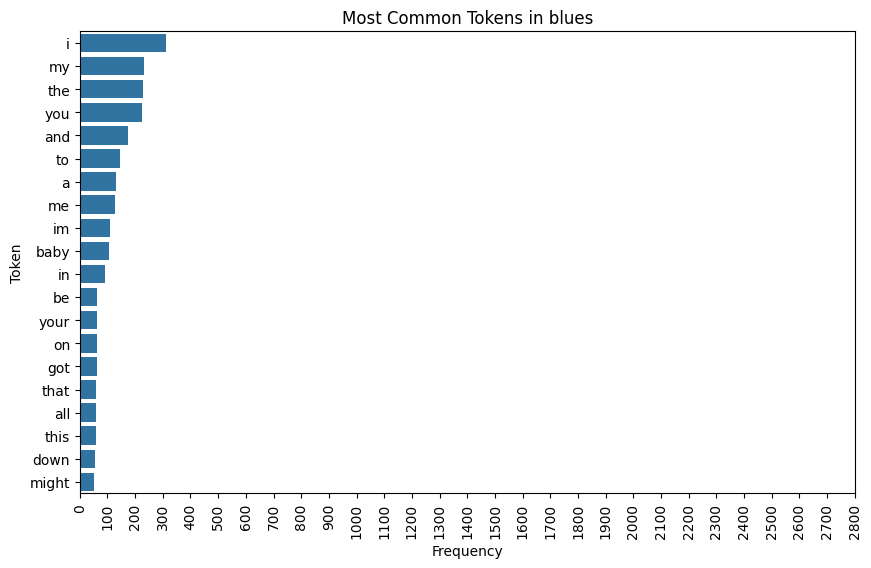

<ipython-input-13-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


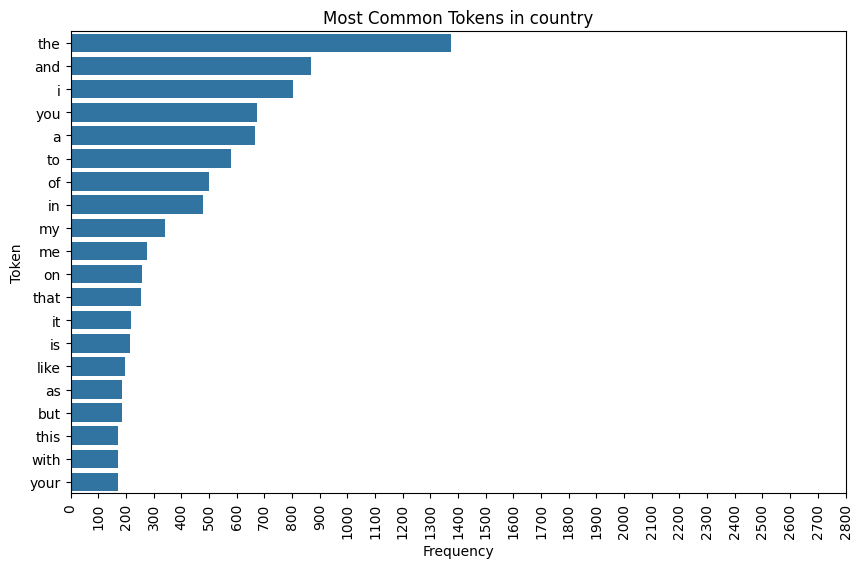

<ipython-input-13-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


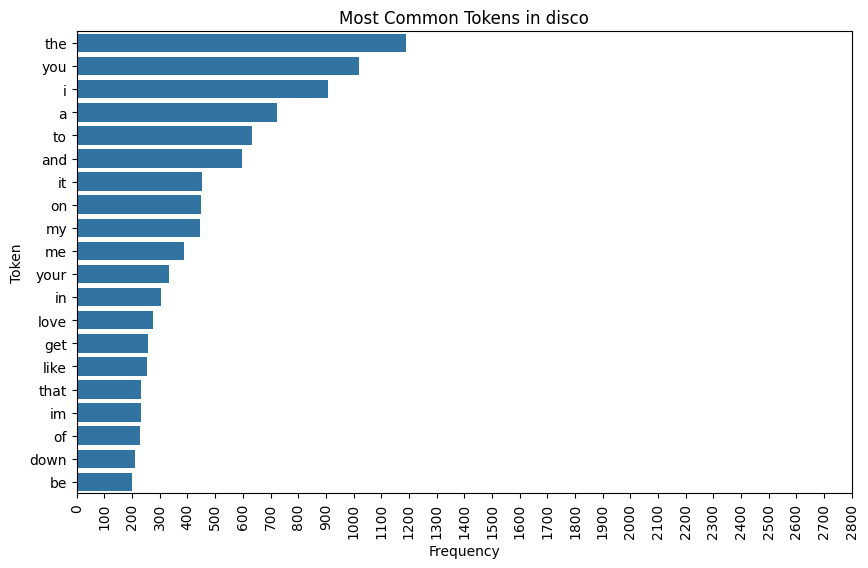

<ipython-input-13-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


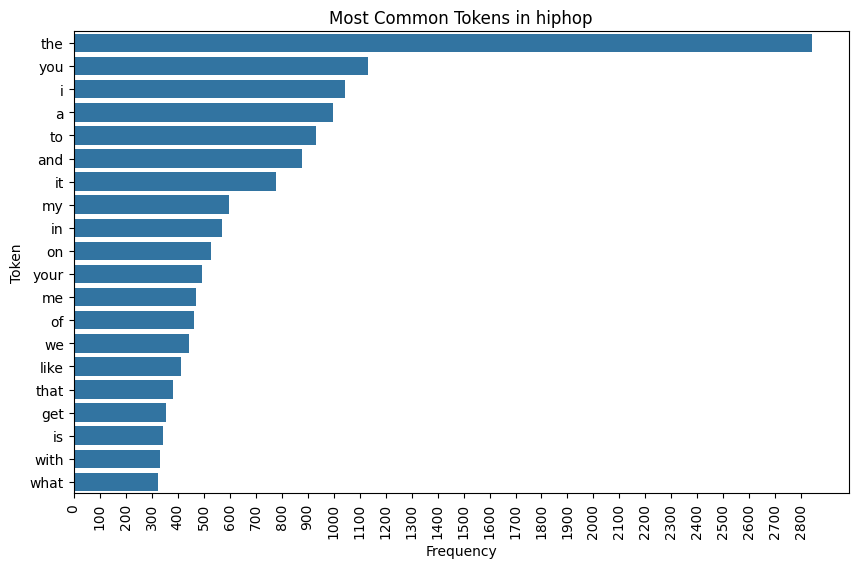

<ipython-input-13-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


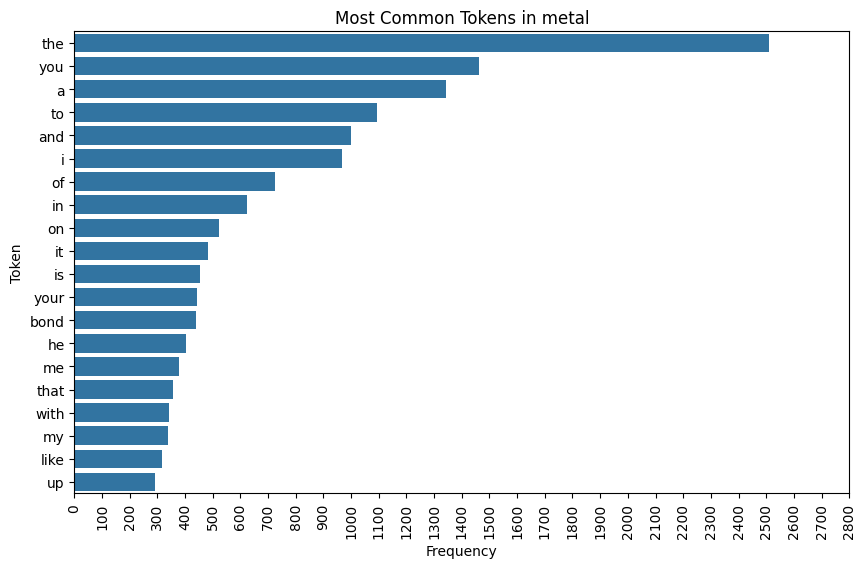

<ipython-input-13-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


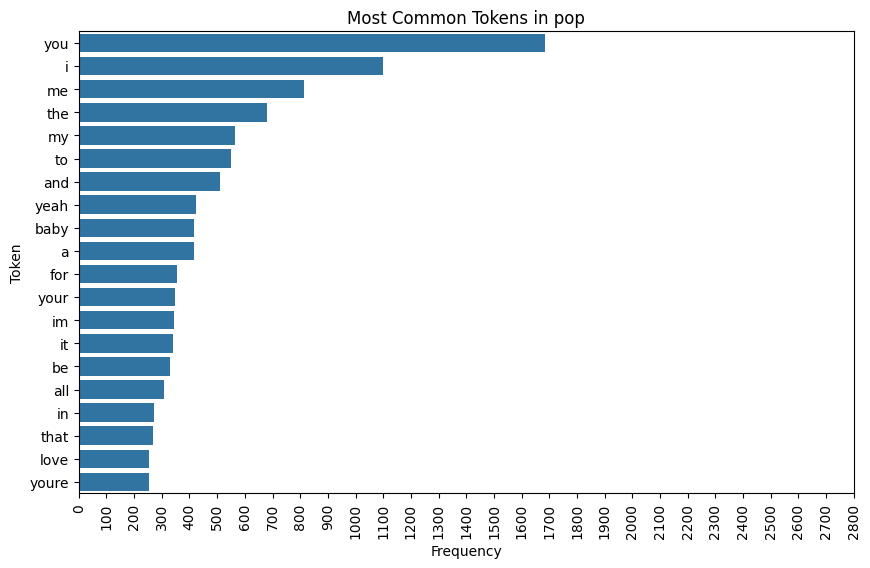

<ipython-input-13-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


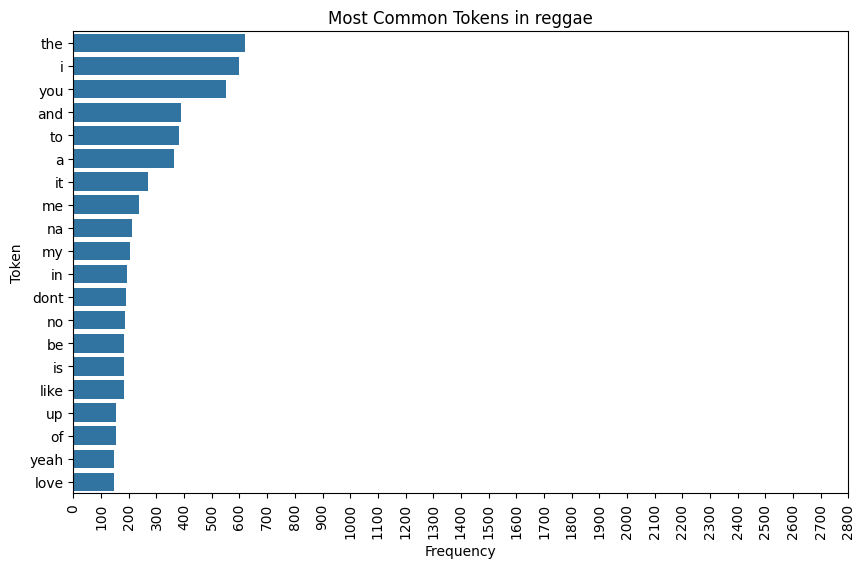

<ipython-input-13-44e37876299c>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts, y=tokens, ci=None)


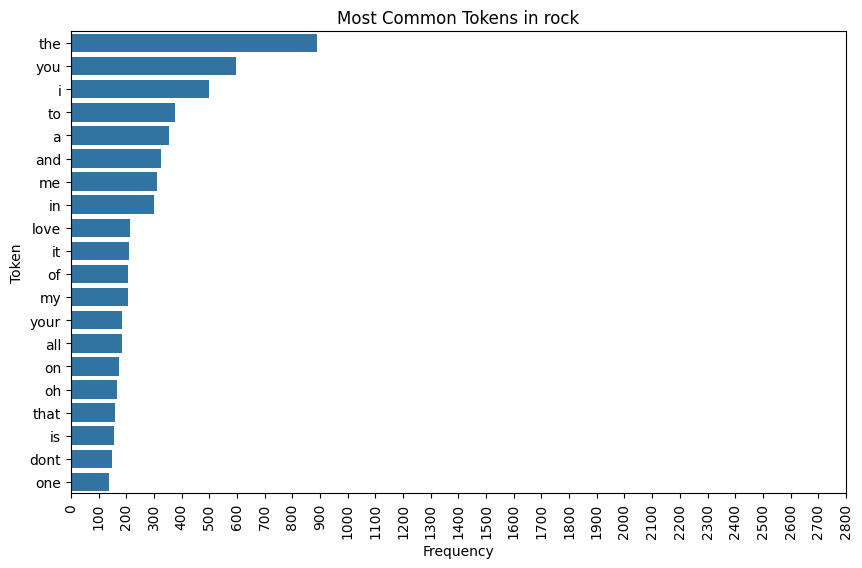

<ipython-input-13-44e37876299c>:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=counts_all, y=tokens_all, ci=None)


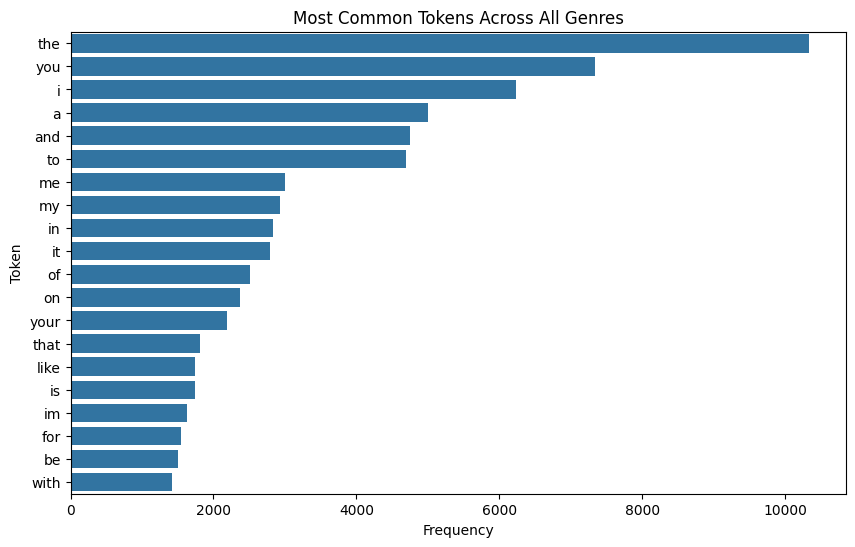

In [13]:
max_count = max(max(sublist[1] for sublist in sublist_list) for sublist_list in most_common_per_genre.values())
x_ticks = np.arange(0, max_count + 1, 100)

# Plot most common tokens per genre
for genre, common_tokens in most_common_per_genre.items():
    tokens, counts = zip(*common_tokens)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=tokens, ci=None)
    plt.title(f"Most Common Tokens in {genre}")
    plt.xlabel("Frequency")
    plt.ylabel("Token")
    plt.xticks(x_ticks, rotation=90)
    plt.show()

# Plot most common tokens across all genres
tokens_all, counts_all = zip(*most_common_all_genres)
plt.figure(figsize=(10, 6))
sns.barplot(x=counts_all, y=tokens_all, ci=None)
plt.title("Most Common Tokens Across All Genres")
plt.xlabel("Frequency")
plt.ylabel("Token")
plt.show()

(32, 80000)
(32,)


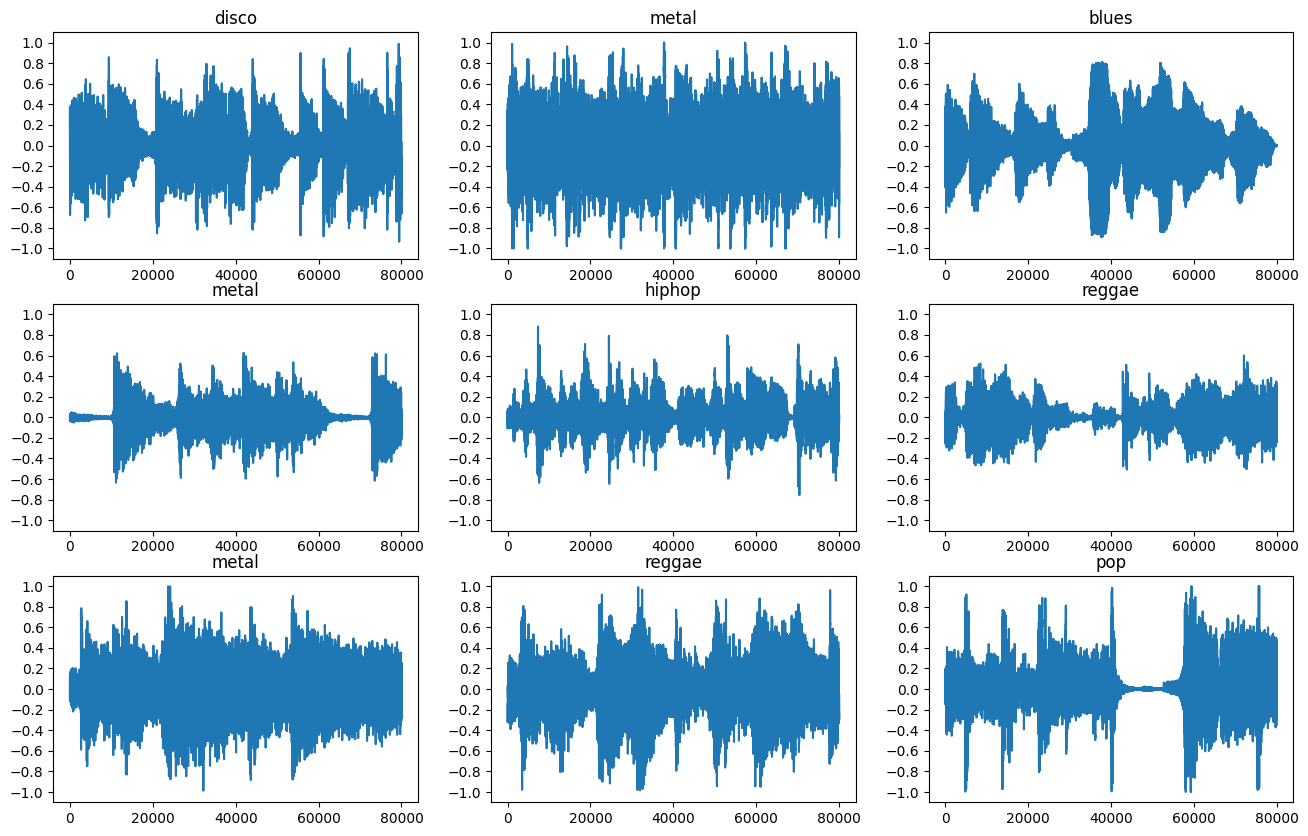

In [14]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

label_names[[1,1,0,0]]
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

## Opdracht 2 - LSTM voor audioclips <a name='audio'></a>

Voor feature engineren hebben wij ervoor gekozen om Mel-frequency cepstral coefficients (mfcc) toe te passen. MFCC's zijn een compact aantal eigenschappen die de algemene vorm van het frequentiespectrum van een geluidssignaal samenvatten. We hebben voor MFCC gekozen omdat deze robuust zijn tegen veranderingen in toonhoogte en luidheid, dit is handig aangezien de verschillende genres kunnen varieren in toonhoogte. Ook kunnen MFCC's helpen bij het vastleggen van subtiele verschillen in klankkleur. MFCC's helpen ook bij het verminderen van ruis en onnodige details in de audiodata. (Deruty, 2022)

De code hieronder komen voor een groot deel uit de lesopdracht 'LSTM_voor_timeseries_data_–_classificatie_van_audioclips'

In [15]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=512, frame_step=256)

    # Obtain the magnitude of the STFT (use tf.abs).
    spectrogram = tf.abs(spectrogram)

    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram

In [16]:
def make_spec_ds(ds):
    return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [18]:
#even kijken of het zo werkt
def make_spec_ds(ds):
    return ds.map(
      map_func=lambda audio: (get_spectrogram(audio),),  # Geen label doorgeven
      num_parallel_calls=tf.data.AUTOTUNE)

test_spectrogram_ds = make_spec_ds(test_ds)


In [19]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [20]:
def spectrogram_to_mfcc(spectrograms, num_mel_bins=128, num_coefficients=13, sample_rate=16000):
    """
    Convert a batch of spectrograms to a batch of 1D time series of MFCCs.

    Parameters:
    - spectrograms: A TensorFlow Tensor representing a batch of spectrograms with shape (batch_size, 311, 257, 1).
    - num_mel_bins: Number of Mel bins to use.
    - num_coefficients: Number of MFCC coefficients to return.
    - sample_rate: Sample rate of the audio.

    Returns:
    - A TensorFlow Tensor containing the MFCCs with shape (batch_size, num_frames, num_coefficients).
    """
    # Remove the last dimension (channel dimension, if it's 1)
    spectrograms = tf.squeeze(spectrograms, axis=-1)

    # Compute Mel spectrograms
    stfts_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=spectrograms.shape[-1],
        sample_rate=sample_rate,
        lower_edge_hertz=20.0,
        upper_edge_hertz=sample_rate / 2)
    mel_spectrograms = tf.tensordot(spectrograms, stfts_to_mel_matrix, 1)
    # Shape tuning for the mel spectrograms as expected
    mel_spectrograms.set_shape(spectrograms.shape[:-1] + (num_mel_bins,))

    # Logarithmic scaling
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_coefficients]

    return mfccs

In [21]:
def make_MFCC_ds(ds):
    return ds.map(
      map_func=lambda spectrogram,label: (spectrogram_to_mfcc(spectrogram), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [22]:
train_MFCC_ds = make_MFCC_ds(train_spectrogram_ds)
val_MFCC_ds = make_MFCC_ds(val_spectrogram_ds)

In [23]:
#even kijken of het zo werkt
def make_MFCC_ds(ds):
    return ds.map(
      map_func=lambda spectrogram: (spectrogram_to_mfcc(spectrogram)),
      num_parallel_calls=tf.data.AUTOTUNE)

test_MFCC_ds = make_MFCC_ds(test_spectrogram_ds)

In [24]:
train_MFCC_ds = train_MFCC_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_MFCC_ds = val_MFCC_ds.cache().prefetch(tf.data.AUTOTUNE)
test_MFCC_ds = test_MFCC_ds.cache().prefetch(tf.data.AUTOTUNE)

### LSTM
We hebben verschillende LSTM modellen getrainen om te kijken welke het beste werkt. Voor optimizer hebben wij gekozen voor ADAM, deze past de leersnelheid van elk parametergewicht aan op basis van de schattingen van het eerste moment en het tweede moment van de gradiënte. (Team, z.d.) De loss functie waar wij gebruik van maken is de SparseCategoricalCrossentropy. Deze wordt gebruikt bij het categoriseren van 2 of meerdere label classen. (Team, z.d.-b) Daarnaast hebben we gekozen voor een Early stopping met een patience van 20 zodat het trainingsproces vroegtijdig stopt als er gedurende een bepaald aantal epochs geen verbetering meer is in de vall los van het model. Hierdoor voorkom je overfitten en het bespaart ook tijd met het trainen.

In [29]:
#LSTM model 1
model_lstm = models.Sequential([
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=32)),
    Dropout(0.2),
    Dense(8, activation='softmax')
])


In [26]:
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [27]:
model_lstm.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

Dit LSTM-model bestaat uit meerdere lagen:

Een bidirectionele laag met 64 units. De laag stelt het model in staat om zowel naar voren als naar achteren door de gegevenssequentie te kijken. Hier door krijgt het model een dieper begrip kan krijgen van de context van de invoergegevens. Een dropout-laag met een dropout-waarde van 0.20, wat betekent dat tijdens het trainen 20% van de getrainde gegevens wordt uitgeschakeld om overfitting te voorkomen. Een tweede bidirectionele laag met 32 units. Deze laag bouwt voort op de eerdere bidirectionele laag en verfijnt de representaties verder. Opnieuw een dropout-laag met een dropout-waarde van 0.20 om overfitting te verminderen. Tot slot een dense laag met 8 uitgangen, aangezien er 8 verschillende muziekgenres zijn die voorspeld moeten worden. De softmax-activatiefunctie wordt gebruikt om de kansverdeling over de verschillende klassen te berekenen.

In [ ]:
EPOCHS = 50

history = model_lstm.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)
)

best_val_score = min(history.history['val_loss'])
best_loss = min(history.history['loss'])
print("Beste validatiescore:", best_val_score)
print("Beste trainingsloss:", best_loss)

In [ ]:
#LSTM model 2

model_lstm_2 = models.Sequential([
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=32, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=16)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')
])

model_lstm_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 50
history_2 = model_lstm_2.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=EPOCHS,
)

best_val_score_2 = min(history_2.history['val_loss'])
best_loss_2 = min(history_2.history['loss'])
print("Beste validatiescore:", best_val_score_2)
print("Beste trainingsloss:", best_loss_2)

In [ ]:
#LSTM model 3

model_lstm_3 = models.Sequential([
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')
])

model_lstm_3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

EPOCHS = 50

history_3 = model_lstm_3.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)
)

best_val_score_3 = min(history_3.history['val_loss'])
best_loss_3 = min(history_3.history['loss'])
print("Beste validatiescore:", best_val_score_3)
print("Beste trainingsloss:", best_loss_3)

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Opdracht 3 - LSTM voor songteksten <a name='song_lstm'></a>

Alle code is gemaakt met behulp van ChatGPT.  
[ChatGPT, Prompt: Preprocess text](https://chat.openai.com/share/23851467-f3c1-4ab7-a520-ce6f3e93bc8d)  
[ChatGPT, Prompt: LSTM Model Input Error](https://chat.openai.com/share/87bf7e53-56c5-4fd7-ac24-236f9f47ebf9)  
[ChatGPT, Prompt: Lower text](https://chat.openai.com/share/3d02c6cd-6317-4eb8-a171-864d7a67873c)  
[ChatGPT, Prompt: Model error](https://chat.openai.com/share/1ab1e7fb-5b2f-41c9-8c28-182b9d584c50)  
[ChatGPT, Prompt: Text Preprocessing & Embedding](https://chat.openai.com/share/14b384fc-55f4-4ef3-b5df-699f256dc903)  
[ChatGPT, Prompt: Preprocess Text: Corrections Made](https://chat.openai.com/share/9a0924be-1a99-4e08-b269-fa10cb08b4b1)  
[ChatGPT, Prompt: Overfitting indicated by loss and accuracy score](https://chat.openai.com/share/fc5c120f-dc1f-4203-ab43-9c111367aeb3)  

De dataframe heeft als index de filename en de kollomen zijn lyrics en genre. We maken gebruik van LabelEncoder om een encoded genre te maken, zodat de target/labels numeriek zijn.

In [ ]:
genres = list(set(train['genre']))

label_encoder = LabelEncoder()

# Fit label encoder and transform the genre labels into numbers
encoded_labels = label_encoder.fit_transform(genres)

# Print the mapping between genres and encoded labels
label_mapping = dict(sorted(zip(genres, encoded_labels)))
print("Label mapping:", label_mapping)

train['genre_encoded'] = train['genre'].map(label_mapping)

display(train)

In [ ]:
def df_to_dataset(dataframe, target, num_classes, batch_size=32, shuffle=True):
    '''Takes a dataframe with lyrics, target and number of classes to turn them to a training and validation dataset.

    Parameters:
    -----------
      dataframe: Dataframe.
      target: str, target column (labels).
      num_classes: int, amount of set classes.

    Returns:
    --------
      train_ds: tensorflow.python.data.ops.batch_op._BatchDataset, training dataset.
      val_ds: tensorflow.python.data.ops.batch_op._BatchDataset, validation dataset.
    '''
    dataframe = dataframe.copy()
    if shuffle:
      dataframe = dataframe.reset_index().sample(frac=1).set_index('filename')

    train_size = int(0.8 * len(dataframe))

    # Split dataframe into training and validation sets
    train_df = dataframe[:train_size]
    val_df = dataframe[train_size:]
    train_labels = to_categorical(train_df.pop(target), num_classes)
    val_labels = to_categorical(val_df.pop(target), num_classes)

    train_ds = tf.data.Dataset.from_tensor_slices((train_df['lyrics'].values, train_labels))
    train_ds = train_ds.batch(batch_size)

    val_ds = tf.data.Dataset.from_tensor_slices((val_df['lyrics'].values, val_labels))
    val_ds = val_ds.batch(batch_size)
    return train_ds, val_ds

In [ ]:
dataframe = train[['lyrics', 'genre_encoded']]
num_classes = len(set(dataframe['genre_encoded']))
train_text_ds, val_text_ds = df_to_dataset(dataframe, 'genre_encoded', num_classes)

Voor de vectorize layer is er een custom_standardization functie gemaakt om de lyrics te preprocessen. De preprocessing bestaat uit:  
1. Alles uit de text tot klein letters gemaakt.
2. Alle new lines (\n) verplaats met een spatie.
3. Alles in rechte haakjes verplaats met een spatie (Er wordt in rechte haakjes de Chorus, Verse of andere termen gewezen).
4. Alle leestekens weggehaald.  
  
We hebben dan schonere teksten voor de vectorize layer, met max_tokens en output_sequence_length hopen we voor een goede kwaliteit van de vectorize layer.  
De embedding layer is om voor elk woord een dense vector te maken, zodat de woorden een connectie hebben met elkaar.


In [ ]:
def custom_standardization(text):
    # Lowercase text
    text = tf.strings.lower(text)
    # Remove new lines
    text = tf.strings.regex_replace(text, r'\n', ' ')
    # Remove anything in square brackets
    text = tf.strings.regex_replace(text, r'\[.*?\]', '')
    # Remove punctuation
    punctuation = string.punctuation
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(punctuation), '')
    return text

vocab_size = 10000
sequence_length = 120

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_text_ds.map(lambda x, y: x)
text_ds = text_ds.unbatch()  # Unbatch the dataset to get individual text samples

# Extract the text data from the dataset
texts = [text.numpy().decode('utf-8') for text in text_ds]
vectorize_layer.adapt(texts)

embedding_layer = Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=64, mask_zero=True)

In [ ]:
model_text_lstm = Sequential([
    vectorize_layer,
    embedding_layer,
    GRU(128, return_sequences=True, dropout=0.2),
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.2)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_text_lstm.summary()

Het model bestaat eerst uit vectorized_layer en embedding_layer, daarna hebben we willekeurig een GRU en Bidrectional met LSTM layers geplaatst. Dan een Dense naar een output met softmax als activation, omdat we te maken hebben met multiple classes. In dit geval 8.

In [ ]:
epochs=50

# Compile
model_text_lstm.compile(optimizer=tf.keras.optimizers.Adam(),
                          loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['accuracy'])

## Add early stopping to the tuning process
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train
history = model_text_lstm.fit(train_text_ds,
                              batch_size = 32,
                                validation_data=val_text_ds,
                                epochs=epochs)

Willekeurig 5000 epochs gekozen om te zien hoe ver de training gaat. De EarlyStopping monitor de val_loss en heeft de training gestopt in 5 epochs. Besloten om dan 50 epochs te doen en zien wat de resultaten zijn.

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Opdracht 4 - Transformer voor songteksten <a name='song_tran'></a>

### BERT model
Voor deze opdracht gebruiken wij het BERT model, dit is een vrij klein model wat goed is omdat het lokaal gerunt kan worden. Ook is het een transformer model dat getrained is op een grote dataset van text waardoor het model goede generalisaties in text kan herkennen en dus beter is in het voorspellen van genres gebaseerd op lyrics. Het model gebruikt de voorgetrainde kennis om de voorspellingen goed uit te kunnen voeren zonder hier enorme hoeveelheden data voor nodig te hebben. (Google-bert/Bert-base-uncased · Hugging Face, 2001)

#### Modelnaam
model: bert-base-uncased

#### Training data
Het BERT-model werd vooraf getraind op BookCorpus, een dataset bestaande uit 11.038 niet-gepubliceerde boeken en de Engelstalige Wikipedia (zonder lijsten, tabellen en kopteksten). (Google-bert/Bert-base-uncased · Hugging Face, 2001)

BookCorpus: https://yknzhu.wixsite.com/mbweb<br>
English Wikipedia: https://en.wikipedia.org/wiki/English_Wikipedia

In [ ]:
batch_size = 8
num_train_epochs = 12
num_train_steps = (len(train['lyrics']) // batch_size) * num_train_epochs
label2id = label_dict = train[['genre', 'genre_encoded']].drop_duplicates().set_index('genre').to_dict()['genre_encoded']
id2label = {i: label for label, i in label_dict.items()}

In [ ]:
model_checkpoint = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
train['tokenized'] = train['lyrics'].apply(lambda lyrics: tokenizer(lyrics, truncation=True, padding='max_length', max_length=512)['input_ids'])

In [ ]:
train_data, eval_data = train_test_split(train, test_size=0.2)

train_dataset = Dataset.from_pandas(train_data).to_tf_dataset(
    columns=['tokenized'],
    label_cols=["genre_encoded"],
    shuffle=True,
    batch_size=batch_size,
)

eval_dataset = Dataset.from_pandas(eval_data).to_tf_dataset(
    columns=['tokenized'],
    label_cols=["genre_encoded"],
    shuffle=True,
    batch_size=batch_size,
)

### Training/fine-tuning het BERT model op de train dataset
Voor het finetunen van het BERT model op de songteksten is eerst de dataset ingeladen en zijn de labels ge-encoded naar nummerieke data zodat dit gebruikt kan worden. Daarna is door de AutoTokenizer de song lyrics getokenized en deze worden vervolgens omgezet naar een Tensorflow dataset met de kolom 'tokenized' (de getokenizede lyrics) als columns en 'genre_encoded' (de numerieke genres) als label_cols. Dit gebeurd allemaal in cellen hierboven

Als laatst is het alleen nog noodzakelijk een optimizer te definieren en het model te trainen. De optimizer gebruikt een learning rate van 2e-5 wat zorgt voor een mooie fit in een lage hoeveelheid epochs, daarnaast hebben we weight decay toegepast als vorm van regularisatie die zorgt dat het model niet te snel zal overfitten. Alle hyperparameters zijn experimenteel gevonden om te zorgen dat er een juiste balans is tussen de snelheid waarin er geleerd wordt en de resultaten die behaald worden.

Met deze optimizers hebben we experimenteel gezien dat tussen de 8 en 12 epochs de optimale scores behaalt worden en dat als er meer epochs worden uitgevoerd dat het model overfit.

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=len(label2id), id2label=id2label, label2id=label2id
)


optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=0,
)

model.compile(optimizer=optimizer)

model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=num_train_epochs
)

## Opdracht 5 - Model naar keuze <a name='mnk'></a>

We hebben besloten om een multi-input model te gebruiken, zodat het vanuit verschillende perspectieven naar de muziek kan kijken. Dit zal zorgen voor een accurater model. Het gebruik van meerdere invalshoeken in het model kan de prestaties ervan verbeteren.

In [32]:
from keras.preprocessing.sequence import pad_sequences

# Tokens maken van de zinnen in de data
tokenized_data = [word_tokenize(zin.lower()) for zin in train['lyrics']]

# Lengte van de langste zin bepalen
max_lengte = max([len(tokens) for tokens in tokenized_data])

# Padding toevoegen om ervoor te zorgen dat alle sequenties dezelfde lengte hebben
padded_tokenized_data = pad_sequences(tokenized_data, maxlen=max_lengte, padding='post', dtype=object)
padded_tokenized_data.shape

(537, 29712)

In [33]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Concatenate

# Multi-input model
inputA = tf.keras.Input(shape=(537, 29712))
inputB = tf.keras.Input(shape=(537, 29712))

# Model x
x = Dense(8, activation="relu")(inputA)
x = Dense(4, activation="relu")(x)
x_output = Model(inputs=inputA, outputs=x)

# Model y
y = Dense(64, activation="relu")(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(4, activation="relu")(y)
y_output = Model(inputs=inputB, outputs=y)

# Combine outputs of x and y
combined = Concatenate()([x, y])

# Model z
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="linear")(z)

# Define final model
model = Model(inputs=[inputA, inputB], outputs=z)

In [ ]:
from tensorflow.keras.optimizers import Adam
from gensim.models import Word2Vec

# Train een Word2Vec-model op je tokenized data
word2vec_model = Word2Vec(sentences=padded_tokenized_data, vector_size=100, window=5, min_count=1, workers=4)

# Vervang de tekstuele tokens door hun overeenkomstige Word2Vec-embeddings
embedded_data = np.array([np.mean([word2vec_model[token] for token in tokens], axis=0) for tokens in padded_tokenized_data])

model.compile(optimizer=Adam(), loss='mean_squared_error')
scaler = MinMaxScaler()
x_data_normalized = scaler.fit_transform(embedded_data.reshape(-1, 1)).reshape(embedded_data.shape)
y_data_normalized = scaler.fit_transform(test['genre_encoded'].reshape(-1, 1)).reshape(test['genre_encoded'].shape)

# Train het model
history = model.fit(padded_tokenized_data, test['genre_encoded'], epochs=15, batch_size=32)

# Print de trainingsgeschiedenis
for epoch, loss in enumerate(history.history['loss'], 1):
    print(f"Epoch {epoch}/{len(history.history['loss'])} - loss: {loss}")

Exception in thread Thread-21 (_worker_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-23 (_worker_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/gensim/models/word2vec.py", line 1166, in _worker_loop
Exception in thread Thread-22 (_worker_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-24 (_worker_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
        self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
  

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Model Architecture')
# Plot de input laag
plt.scatter(0, 0, s=100, color='blue', label='Input Layer')
# Loop over de lagen van het model en plot ze
for i, layer in enumerate(model.layers):
    if i == 0:
        continue  # Skip de input laag omdat we die al geplot hebben
    plt.scatter(i, 0, s=100, color='orange', label='Hidden Layer' if i == 1 else None)
    plt.plot([i-1, i], [0, 0], color='black')  # Verbindingslijn tussen lagen
plt.scatter(len(model.layers)-1, 0, s=100, color='green', label='Output Layer')

plt.show()

## Opdracht 6 - Bevindingen <a name='bevindingen'></a>

### Overzicht van de resultaten

|model|loss|val loss|
|-----|----|--------|
|LSTM voor audioclips|0.1838|1.4518|
|LSTM voor songteksten|0.0050|4.8882|
|Transformer voor songteksten|0.2149|0.9383|
|Model naar keuze|||

### Beschrijving en overzicht van het best presterende model
#### LSTM voor audioclips
Het model loss is gezakt naar 0.1838, terwijl de val loss omhoog is gegaan naar 1.4518 tijdens het trainen. Dit geeft aan dat het model is gaan overfitten. Vandaar dat de val accuracy wat lager zit dan de accuracy. Dus het model presteert slechter met data dat het model niet kent.

#### LSTM voor songteksten
Hier geldt hetzelfde als bij LSTM voor audioclips. Alleen slechter volgens de scores.

#### Transformer voor songteksten
De transformer is een erg goede keuze, het heeft een lage loss and val_loss die dichter bij elkaar liggen dan andere modellen. Dit geeft aan dat het model niet overfit is en dat het een betrouwbare score is. Ook is de score lager dan bij de andere modellen, dit komt waarschijnlijk omdat de transformer gebruik maakt van alle training die hij hiervoor ook gehad heeft. Bert is getrained op een grote hoeveelheid tekst en gebruikt dit om betere predicties te maken nu dat wij nieuwe data introduceren.

#### Model naar keuze

## Opdracht 7 - Conclusie en aanbevelingen <a name='conclusie'></a>

De uitdagingen van het modeleringsproces waren het omzetten van de data naar bruikbare data voor deep learning, het vinden van het juiste model naar keuze.



LSTM had een betere val_accuracy met de audio data dan met de tekst data. Hieruit concluderen we dat dit model beter werkt met audio data. Transformermodellen zijn goed in het begrijpen van tekstuele gegevens en het ontdekken van patronen daarin maar hebben moeite met complexere data zoals audio data.

Country en Blues muziek gaat vaak over de zelfde thema's. In het geval van country gaat dat vaak over heimwee en het leven op het platteland. in het geval van blues gaat dat vaak over tegenslagen in het leven.

Maak gebruik van meerdere modellen aangezien de modellen apart een lage accuracy hebben en mischien in een ensemble model tot een hogere score komen.

Conceptueel gezien zouden we een systeem kunnen maken waarin liedjes van hetzelfde genre aanbevolen worden. Verder kunnen we in het systeem net zoals in een pointcloud waarin 3d wordt aangegeven hoe ver twee dingen van elkaar afstaan aangeven hoe ver genres van elkaar afstaan en kunnen we daarmee genres aanbevelen die de luisteraar misschien goed vindt op basis van de andere genres waar hij/zij naar luistert.

### Deelvragen beantwoord
Voor het modellerings proces moest alle data omgezet worden in de juiste datatypes en vervolgens hebben we lstm getrained op de tekst en de audio (beide aparte modellen, geen multimodaliteit) en een transformer van huggingface op de tekst. Het was hierbij vooral lastig alle data op te schonen en in de modellen te krijgen. Zo had de tekst bijvoorbeeld veel speciale characters die verwijderd moesten worden en dit was moeilijker dan gedacht. Vervolgens was het ook lastig om te werken met de huggingface transformers library aangezien de documentatie erg onduidelijk was. Huggingface heeft wel veel documentatie en tutorials op hun website maar toch was het lastiger doorheen te spitten dan bijvoorbeeld numpy, matplotlib of scikit-learn.

Van alle modelarchitecturen hebben we gezien dat de transformer het beste werkt. We denken dat dit komt doordat het model is voorgetraind op een grote hoeveelheid data. Hierdoor kan het model betere linken leggen tussen de betekenissen van woorden en daardoor hoeft het niet veel data te hebben om getrained te worden voor nieuwe doeleindes zoals het classificeren van muziekgenres.

Voor de audiofragmenten hebben wij alleen de lstm en voor de lyrics hadden wij lstm en transformer, hierbij werkte de transformer het beste. In de alinea hierboven hebben wij beschreven waarom wij dat denken.

als je een geautomatiseerde app voor audioclassificatie zou willen maken dan is het van belang dat het transformer model kan worden gebruikt op het apparaat waar de app op geinstalleerd wordt. Het kiezen van het meest krachtige model wat nog steeds kan runnen is van groot belang. ook is het goed om te zorgen dat er een goede UI/UX is aangezien dat vaak een van de belangrijkste dingen is bij het ontwikkelen van een app.

om dit uit te kunnen breiden naar muziekaanbevelingen is het belangrijk dat er meer dingen meegenomen worden dan alleen de genres. wellicht kunnen andere aspecten van de muziek die geluisterd word ook meegenomen worden zoals de artiesten en/of bpm van de nummers. Dit alles kan worden gebruikt voor een nieuw model die kan zorgen dat er muziek aanbevolen wordt die lijkt op de muziek die al geluisterd wordt.

## Bronnenlijst <a name='bronnenlijst'></a>


- Team, K. (z.d.). Keras documentation: Adam. https://keras.io/api/optimizers/adam/
- Team, K. (z.d.-b). Keras documentation: Probabilistic losses. https://keras.io/api/losses/probabilistic_losses/
- Deruty, E. (2022, 15 december). Intuitive understanding of MFCCs - Emmanuel
- Deruty - Medium. Medium. https://medium.com/@derutycsl/intuitive-understanding-of-mfccs-836d36a1f779
- Google Colab. (z.d.). https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/tensorflow/training.ipynb
- google-bert/bert-base-uncased · Hugging Face. (2001, 11 maart). https://huggingface.co/google-bert/bert-base-uncased
- Home | mbweb. (z.d.). Mbweb. https://yknzhu.wixsite.com/mbweb
- Wikipedia contributors. (2024, 29 april). English Wikipedia - Wikipedia. https://en.wikipedia.org/wiki/English_Wikipedia
- ChatGPT, Prompt: Preprocess text. https://chat.openai.com/share/23851467-f3c1-4ab7-a520-ce6f3e93bc8d
- ChatGPT, Prompt: LSTM Model Input Error. https://chat.openai.com/share/87bf7e53-56c5-4fd7-ac24-236f9f47ebf9
- ChatGPT, Prompt: Lower text. https://chat.openai.com/share/3d02c6cd-6317-4eb8-a171-864d7a67873c
- ChatGPT, Prompt: Model error. https://chat.openai.com/share/1ab1e7fb-5b2f-41c9-8c28-182b9d584c50
- ChatGPT, Prompt: Text Preprocessing & Embedding. https://chat.openai.com/share/14b384fc-55f4-4ef3-b5df-699f256dc903
- ChatGPT, Prompt: Preprocess Text: Corrections Made. https://chat.openai.com/share/9a0924be-1a99-4e08-b269-fa10cb08b4b1
- ChatGPT, Prompt: Overfitting indicated by loss and accuracy score. https://chat.openai.com/share/fc5c120f-dc1f-4203-ab43-9c111367aeb3
- Les opdrachten

